In [13]:
import scPhyloX as spx
import numpy as np
import pandas as pd
import gzip
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
import pickle
from scipy.integrate import quad, solve_ivp
from scipy.stats import poisson, chisquare
import os

In [2]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['font.size'] = 12

In [3]:
os.chdir('../')

In [4]:
with gzip.open('datasets/simulation/overshoot/character_matrix.csv.gz', 'rb') as f:
    charater_matrix = pd.read_csv(f, index_col=0)
charater_matrix = charater_matrix.to_numpy()
with gzip.open('datasets/simulation/overshoot/simulation_data.csv.gz', 'rb') as f:
    ground_truth = pd.read_csv(f, index_col=0)
ground_truth = ground_truth.to_numpy()
ground_truth = ground_truth[np.arange(0, ground_truth.shape[0], 1000)]
time = ground_truth[:, 0]
cell_number = ground_truth[:, 1:]

In [5]:
mutnum = spx.data_factory.get_mutnum(charater_matrix)
branch_len = spx.data_factory.get_branchlen(charater_matrix)

100%|██████████| 125250/125250 [00:05<00:00, 21669.88it/s]


In [6]:
d, p, r, a, b, k, t0 = (0.01, 0.6, 0.4, 0.9, 0.1, 0.3, 12)
# ax, bx = (1+p)*a, b*(1+p)+1-p
T = 35
t = range(T)
x0 = [100, 0]
sol = solve_ivp(spx.est_tissue.cellnumber, t_span=(0, T), y0=x0, t_eval=range(T+1),
                method='RK45', args=(a, b, k, t0, p, r, d))

Text(0, 0.5, 'Cell number')

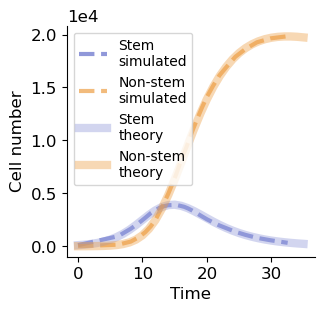

In [14]:
fig, ax = plt.subplots(figsize=(3.2, 3))
ax.plot(time, cell_number[:, 0], '--', lw=3, label='Stem\nsimulated', c='#9098d9')
ax.plot(time, cell_number[:, 1], '--', lw=3, label='Non-stem\nsimulated', c='#ed9e44', alpha=0.7)
ax.plot(sol.t, sol.y[0], label='Stem\ntheory', c='#9098d9', lw=6, alpha=0.4)
ax.plot(sol.t, sol.y[1], label='Non-stem\ntheory', c='#ed9e44', lw=6, alpha=0.4)
ax.legend(loc=2,fontsize=10)
ax.ticklabel_format (style='sci', scilimits= (-1,2), axis='y')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Time')
ax.set_ylabel('Cell number')

In [8]:
idata = pickle.load(open('datasets/simulation/overshoot/para_inf.pkl', 'rb'))
idata_bl = pickle.load(open('datasets/simulation/overshoot/mutrate_inf.pkl', 'rb'))
theta_h = az.summary(idata).loc['ax,bx,r,d,k,t0'.split(',')]['mean'].to_numpy()

/home/wangkun/miniconda3/lib/python3.9/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


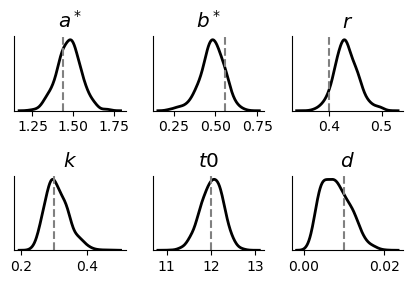

In [9]:
ax, bx = (1+p)*a, b*(1+p)+1-p
gt = [ax, bx, r, k, t0, d]
fig, ax = plt.subplots(2, 3, figsize=(4.3, 3))
for ind, sym in enumerate('ax,bx,r,k,t0,d'.split(',')):
    sns.kdeplot(idata.posterior[sym].to_numpy().flatten(), bw_adjust=2, ax=ax[ind//3][ind%3], lw=2, color='black')
    ax[ind//3][ind%3].set_title(f"${sym.replace('x', '^*')}$")
    ax[ind//3][ind%3].set_ylabel('')
    ax[ind//3][ind%3].set_yticklabels('')
    ax[ind//3][ind%3].tick_params(left=False)
    ylim = ax[ind//3][ind%3].get_ylim()
    ax[ind//3][ind%3].vlines(gt[ind], *ylim, color='grey', ls='--')
    ax[ind//3][ind%3].set_ylim(ylim)
    ax[ind//3][ind%3].tick_params(axis='x', labelsize=10)
    ax[ind//3][ind%3].spines['right'].set_visible(False)
    ax[ind//3][ind%3].spines['top'].set_visible(False)
plt.tight_layout()

In [10]:
n_cyclingcells = np.array([[spx.est_tissue.ncyc(i, j, 100, *theta_h) for j in range(T)] for i in range(100)])
n_noncyclingcells = np.array([[spx.est_tissue.nnc(i, j, 100, *theta_h) for j in range(T)] for i in range(100)])

lp_Power_divergenceResult(statistic=0.13853071748300083, pvalue=0.999638361551232)
lr_Power_divergenceResult(statistic=0.008769196264595613, pvalue=0.9997821707208558)


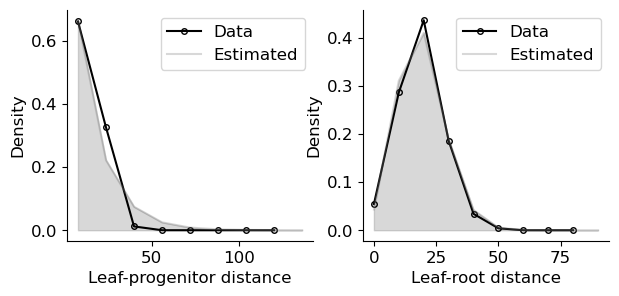

In [12]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3))

max_val = 130
n_hist = 8
xrange = np.arange(0, max_val, int(max_val/n_hist))+int(max_val/n_hist)/2
dist = np.histogram(branch_len+1, xrange-int(max_val/n_hist)/2)
th_dist = [spx.est_mr.BranchLength(*az.summary(idata_bl)['mean']).prob(i) for i in xrange]
    
ax[0].plot(xrange[:-1], dist[0]/sum(dist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
ax[0].plot(xrange, th_dist/sum(th_dist), c='tab:grey',alpha=0.3, label='Estimated')
ax[0].fill_between(xrange, th_dist/sum(th_dist), color='tab:grey', alpha=0.3)
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlabel('Leaf-progenitor distance')
ax[0].set_ylabel('Density')
ax[0].legend()
print(f'lp_{chisquare(f_obs = dist[0]/sum(dist[0]), f_exp=th_dist[:-1]/sum(th_dist[:-1]), ddof=2)}')



alpha = n_cyclingcells[:,-1]+n_noncyclingcells[:,-1]
alpha = alpha / sum(alpha)

max_val = 100
n_hist = 10
mutdist = np.histogram(mutnum, np.arange(0, max_val, int(max_val/n_hist)))
th_dist = np.zeros(max_val)
for i, a in enumerate(alpha):
    th_dist = th_dist + a*poisson((i+1)*2).pmf(range(max_val))
th_dist_x = []
th_dist_y = []
for i in range(n_hist):
    th_dist_x.append(i*int(max_val/n_hist))
    th_dist_y.append(np.sum(th_dist[i*int(max_val/n_hist):(i+1)*int(max_val/n_hist)]))
ax[1].plot(mutdist[1][:-1], mutdist[0]/sum(mutdist[0]), 'o-', mfc='none', c='black', ms=4, label='Data')
ax[1].plot(th_dist_x, th_dist_y, c='tab:grey',alpha=0.3, label='Estimated')
ax[1].fill_between(th_dist_x, th_dist_y, color='tab:grey', alpha=0.3)
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel('Leaf-root distance')
ax[1].set_ylabel('Density')
ax[1].legend()
print(f'lr_{chisquare(f_obs = mutdist[0]/sum(mutdist[0]), f_exp=th_dist_y[:-1]/sum(th_dist_y[:-1]), ddof=5)}')